In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

%matplotlib notebook

In [2]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # SVD (singular value decomposition) for (Nx2) matrix A = U*diag(S)*V  where N is the number of points
        # matrix V is 2x2, matrix U is Nx2, and S is a vector (Nx1 array) of eigen values for A
        u,s,v = la.svd(A, full_matrices=False)

        #least square line fit = v' * 1/s * u' * B
        ls_line = np.transpose(v).dot(np.diag(1.0/s)).dot(np.transpose(u).dot(B))
        self.a = ls_line[0]
        self.b = ls_line[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

# RANSAC for robust line fitting  (single model case)

### Step 1: generating noisy data with outliers

<IPython.core.display.Javascript object>


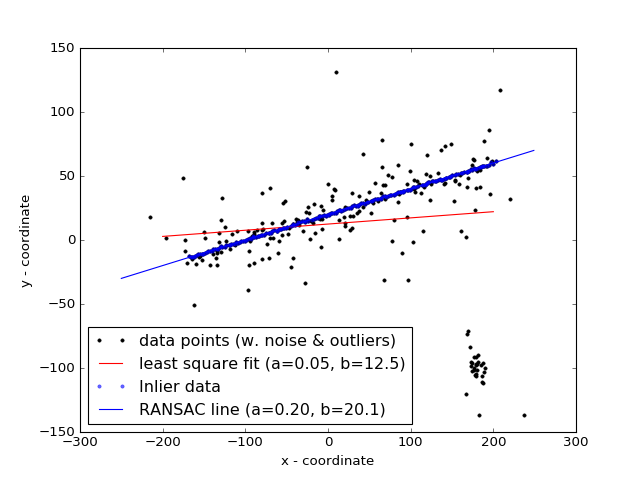

In [3]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Step 2: least-square line fitting

In [4]:
LSline = LeastSquareLine() # uses class implemented at the top of this notebook
print LSline.estimate(data)
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

True


### Step 3: robust line fitting (RANSAC)

In [5]:
# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=1, max_trials=1000)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

# Sequential RANSAC for robust multi-line fitting
### Step 1: generating noisy data with outliers

<IPython.core.display.Javascript object>


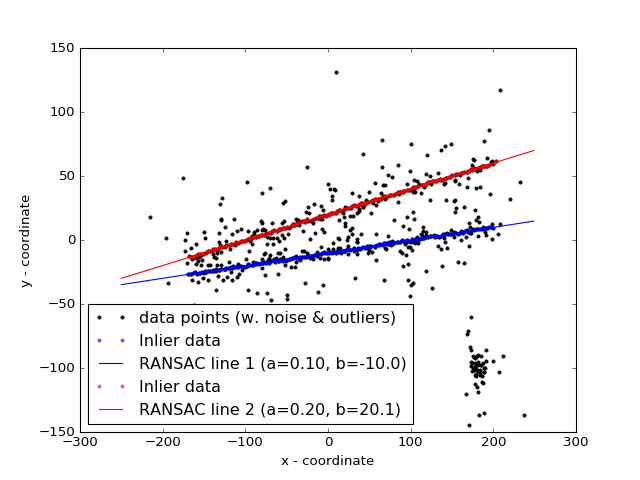

In [6]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Step 2: find a line using RANSAC

In [7]:
model_robust1, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=1, max_trials=1000)
outliers = (inliers == False)
a1_rs, b1_rs = model_robust1.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust1.predict_y(line_x)

ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line 1 (a={:4.2f}, b={:4.1f})'.format(a1_rs,b1_rs))
ax.legend(loc='lower left')
plt.show()

### Step 3: Fit another line after removing inliers for the first line (detected above)

In [8]:
data_remaining = data[outliers]
model_robust2, inliers = ransac(data_remaining, LeastSquareLine, min_samples=2, residual_threshold=1, max_trials=1000)
a2_rs, b2_rs = model_robust2.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust2.predict_y(line_x)

ax.plot(data_remaining[inliers, 0], data_remaining[inliers, 1], '.r', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-r', label='RANSAC line 2 (a={:4.2f}, b={:4.1f})'.format(a2_rs,b2_rs))
ax.legend(loc='lower left')
plt.show()

# Multi-line fitting for (Canny) edges

<IPython.core.display.Javascript object>


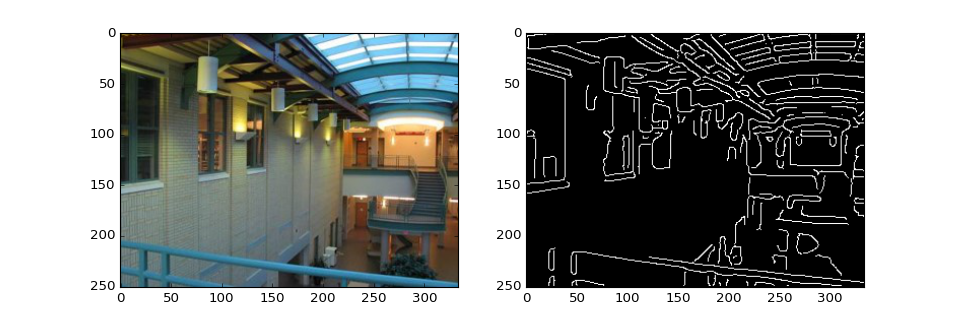

In [9]:
import matplotlib.image as image
from skimage import feature
from skimage.color import rgb2gray

im = image.imread("images/CMU_left.jpg")
imgray = rgb2gray(im)
can = feature.canny(imgray, 2.0)

plt.figure(3,figsize = (12, 4))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(can,cmap="gray")
plt.show()

# Assignment: use sequestial-RANSAC to find $K$ lines

In [10]:
K = 10 
# NOTE 1: write your code using a function that takes K as a parameter. 
#         Its imput should also be a binary image containing any features 
#         (like Canny edges, e.g. binary image "can" above).
# NOTE 2: Present visual results for different values of K 
# NOTE 3: Your code should visually show detected lines in a figure 
#         over the image (either the original one or over the Canny edge mask)
# NOTE 4: To achieve good performance, you may need to play with parameters of function ransac 
#         (e.g. threshold and number of sampled models "max_trials")
#         Also, you can introduce one extra parameter for the minimum number of inliers 
#         for accepting ransac-detected lines.

# NOTE: "can" in the cell above is a binary mask with True and False values, e.g. 
print can[20,30]
print can[146,78]

False
True
